## Adding a new task to ```spred```
--------------------------------------

In this tutorial, we show how to add a new task for evaluating selective
prediction techniques. Specifically, we'll create a task called "normals",
a two-label classification task. Instances for label A are generated from
a mixture of two bivariate normal distributions with means (-1, 0) and (1, 0),
whereas instances for label B are generated from a mixture of two bivariate
normals with means (0, -1) and (0, 1). The covariances are chosen so that most
overlap occurs near the origin, making such points the "most difficult" to 
classify.

![samples from the two mixture distributions](red_blue.png)

For most tasks, we'll already have training data stored in a file somewhere, but for this task, we'll create our own training data. To do so, let's leverage the ```numpy``` package to make a helper function ```generate_samples``` that samples points from a bivariate normal distribution.

In [1]:
from numpy.random import multivariate_normal
from numpy import diag

def generate_samples(means, variances, num_samples, noise_dim=0):
    return multivariate_normal(means + [0.0]*noise_dim,
                               diag(variances + [1.0]*noise_dim),
                               size=num_samples)


The function assumes that the two dimensions are not correlated, so if we make the following call, then we're effectively drawing our ```x``` coordinate from ```Normal(-1.0, 0.2)``` and our ```y``` coordinate from ```Normal(0.0, 0.1)```.

In [2]:
generate_samples(means=[-1.0, 0.0], variances=[0.2, 0.1], num_samples=5)

array([[-0.42400979, -0.28037431],
       [-1.16340207, -0.1547301 ],
       [-1.26352225,  0.35742983],
       [-1.22658115,  0.59460908],
       [-0.78217529, -0.39922637]])

We've also provided an argument called ```noise_dim```, to make the learning task a bit more challenging. This adds extra dimensions, each independently sampled from a standard zero-mean normal.

In [3]:
generate_samples(means=[-1.0, 0.0], variances=[0.2, 0.1], num_samples=5, noise_dim=3)

array([[-0.84281047,  0.22901042, -0.92723795, -0.28562153, -0.51877257],
       [-1.05118761,  0.24416542,  0.77153505, -0.09639673,  2.20070117],
       [-1.33060783,  0.21944966,  0.21465223,  0.89917106,  0.74922109],
       [-1.18171618, -0.32938125, -0.87769102, -0.75722443, -0.96573778],
       [-1.25096351,  0.2363531 ,  0.06616472,  2.46657589,  0.68874332]])

We now need to create a ```Loader``` for this training data, which implements the interface in ```spred.loader```:

    class Loader(ABC):
        @abstractmethod
        def __iter__(self):
            """
            Creates an Iterator over the batches of the Loader.
    
            Each batch should be a dictionary with at least two keys:
            - "inputs": maps to a torch.tensor of shape BxD containing the input
            vectors, where B is batch size and D is input vector dimension
            - "labels": maps to a torch.tensor of shape B containing the
            corresponding labels
    
            """
            ...
    
        @abstractmethod
        def __len__(self):
            """ Number of batches provided by the Loader."""
            ...
    
        @abstractmethod
        def num_labels(self):
            """ Number of class labels in the dataset. """
            ...


In [4]:
import numpy
import torch
from random import shuffle
from spred.loader import Loader

class NormalsLoader(Loader):
    
    def __init__(self, num_batches, bsz, noise_dim):
        super().__init__()
        self.bsz = bsz
        self.num_batches = num_batches
        self.noise_dim = noise_dim
        self.batches = []
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        for _ in range(num_batches):
            variance1 = 0.2
            variance2 = 0.1
            pts1a = generate_samples([-1.0, 0.0], [variance1, variance2], bsz//4, self.noise_dim)
            pts1b = generate_samples([1.0, 0.0], [variance1, variance2], bsz//4, self.noise_dim)
            pts2a = generate_samples([0.0, -1.0], [variance2, variance1], bsz//4, self.noise_dim)
            pts2b = generate_samples([0.0, 1.0], [variance2, variance1], bsz//4, self.noise_dim)
            labeled = ([(pt, 0) for pt in pts1a] +
                       [(pt, 0) for pt in pts1b] +
                       [(pt, 1) for pt in pts2a] +
                       [(pt, 1) for pt in pts2b])
            shuffle(labeled)
            instances = torch.tensor(numpy.array([pair[0] for pair in labeled])).float()
            labels = torch.tensor([pair[1] for pair in labeled])
            self.batches.append((instances, labels))

    def __iter__(self):
        for instances, labels in self.batches:
            yield {'inputs': instances.to(self.device), 'labels': labels.to(self.device)}

    def __len__(self):
        return self.num_batches

    def num_labels(self):
        return 2

For instance, the following code creates a ```Loader``` that provides two batches, each with eight training vectors (half of which are sampled from class 0 and half of which are sampled from class 1).

In [5]:
loader = NormalsLoader(num_batches=2, bsz=8, noise_dim=3)
print('This loader has {} batches.'.format(len(loader)))
print('This loader has {} class labels.'.format(loader.num_labels()))
for batch in loader:
    print(batch)

This loader has 2 batches.
This loader has 2 class labels.
{'inputs': tensor([[ 0.7431, -0.9386,  1.3403, -0.7856,  0.5292],
        [-1.5746, -0.7945,  1.0636, -0.1697, -0.5544],
        [ 0.8429,  0.0522, -2.3533,  0.6586,  1.5231],
        [ 0.0691, -1.0116,  0.9962, -0.1273,  0.9410],
        [-0.5056,  0.0301,  0.0387, -1.1412,  0.5984],
        [ 0.0145,  0.8350,  0.1574, -0.1612, -0.1637],
        [ 0.0841,  1.5974, -0.4095,  0.2248,  0.6716],
        [ 1.1770, -0.2838, -0.1507,  0.7989, -0.0056]]), 'labels': tensor([1, 0, 0, 1, 0, 1, 1, 0])}
{'inputs': tensor([[ 0.1215, -0.4340, -0.6003, -0.7993, -0.8656],
        [ 0.3999,  0.7732, -0.2849, -1.1945, -1.8914],
        [-0.3479, -1.4459,  0.2234, -0.2272,  0.5354],
        [ 0.5429, -0.0284,  1.7770, -1.1569, -0.6091],
        [-1.5384, -0.1584,  1.6475,  0.2868, -0.9035],
        [ 0.1655,  1.7107, -0.7201,  1.3279,  2.6641],
        [ 0.4157, -0.0093,  1.5949, -0.2323,  0.5208],
        [-0.5470, -0.0489, -0.8973, -0.1630,  1.

With our ```Loader``` defined, we can now create a ```Task``` by specifying loaders for the training, validation, and test sets.

In [6]:
from spred.task import Task

class NormalsTask(Task):

    def __init__(self, noise_dim, n_train_batches,
                 n_validation_batches, n_test_batches):
        super().__init__()
        self.noise_dim = noise_dim
        self.n_train_batches = n_train_batches
        self.n_validation_batches = n_validation_batches
        self.n_test_batches = n_test_batches

    def init_train_loader(self, bsz):
        return NormalsLoader(self.n_train_batches, bsz, self.noise_dim)

    def init_validation_loader(self, bsz):
        return NormalsLoader(self.n_validation_batches, bsz, self.noise_dim)

    def init_test_loader(self, bsz):
        return NormalsLoader(self.n_test_batches, bsz, self.noise_dim)

The last thing we need to do is register our new task with the Spred Hub, so that we can use it in selective prediction experiments.

In [7]:
from spred.hub import spred_hub
spred_hub.register_task('nrmls', NormalsTask)

Let's try out some selective prediction techniques on our new task! To run an experiment (i.e. train a neural network and compare the effectiveness of various confidence functions), we first must configure the experiment. To configure the task, we provide the name under which we registered the task (i.e. "nrmls") and the arguments to its constructor.

In [8]:
task_config = {"name": "nrmls",
               "noise_dim": 50,
               "n_train_batches": 200,
               "n_validation_batches": 200,
               "n_test_batches": 100}

Next let's configure the model we want to train. Let's train a simple feedforward neural network with internal layers of size 128 and 64. Note that the input size for our task is 52 (our (x,y) dimensions + 50 noise dimensions) and the output_size is 2 (class A or class B). We'll train using a basic cross-entropy ("ce") loss.

In [15]:
model_config = {"name": "feedforward",
                "input_size": 52,
                "hidden_sizes": [128, 64],
                "output_size": 2,
                "loss": {
                    "name": "ce"
                }}

For this experiment, we'll compare three different confidence functions:
1. **"random"**: just associate a random confidence with each prediction
2. **"max_prob"**: use the softmax probability of the prediction as its confidence
3. **"mcd"**: use the MC Dropout technique of Gal and Ghahramani

In [16]:
confs = [{"name": "random"},
         {"name": "max_prob"},
         {"name": "mcd",
          "aggregator": "mean",
          "n_forward_passes": 10}]

Now that we've specified our task, our model, and our confidences, let's bundle them together into an experiment configuration. We'll also specify a couple extra details, like the optimizer (stochastic gradient descent with momentum of 0.9 and a learning rate of 0.003), the batch size (64), and the number of training epochs (30).

In [17]:
config = {"task": task_config,
          "model": model_config,
          "confidences": confs,
          "optimizer": {"name": "sgd",
                        "lr": 0.003,
                        "momentum": 0.9},
          "bsz": 64,
          "n_epochs": 30}

With our configuration ready, let's run the experiment!

In [19]:
from spred.experiment import Experiment
exp = Experiment(config)
exp_result = exp.run()

Training with config:
{'task': {'name': 'nrmls', 'noise_dim': 50, 'n_train_batches': 200, 'n_validation_batches': 200, 'n_test_batches': 100}, 'model': {'name': 'feedforward', 'input_size': 52, 'hidden_sizes': [128, 64], 'output_size': 2, 'loss': {'name': 'ce'}}, 'confidences': [{'name': 'random'}, {'name': 'max_prob'}, {'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}], 'optimizer': {'name': 'sgd', 'lr': 0.003, 'momentum': 0.9}, 'bsz': 64, 'n_epochs': 30}
Epoch 1:


100%|██████████| 200/200 [00:00<00:00, 1998.96it/s]


Epoch 2:


100%|██████████| 200/200 [00:00<00:00, 2027.88it/s]


Epoch 3:


100%|██████████| 200/200 [00:00<00:00, 2026.84it/s]


Epoch 4:


100%|██████████| 200/200 [00:00<00:00, 2009.95it/s]


Epoch 5:


100%|██████████| 200/200 [00:00<00:00, 2037.05it/s]


Epoch 6:


100%|██████████| 200/200 [00:00<00:00, 1978.98it/s]


Epoch 7:


100%|██████████| 200/200 [00:00<00:00, 2026.73it/s]


Epoch 8:


100%|██████████| 200/200 [00:00<00:00, 2024.48it/s]


Epoch 9:


100%|██████████| 200/200 [00:00<00:00, 2027.06it/s]


Epoch 10:


100%|██████████| 200/200 [00:00<00:00, 2033.99it/s]


Epoch 11:


100%|██████████| 200/200 [00:00<00:00, 2015.74it/s]


Epoch 12:


100%|██████████| 200/200 [00:00<00:00, 2022.71it/s]


Epoch 13:


100%|██████████| 200/200 [00:00<00:00, 2026.50it/s]


Epoch 14:


100%|██████████| 200/200 [00:00<00:00, 2029.53it/s]


Epoch 15:


100%|██████████| 200/200 [00:00<00:00, 2002.32it/s]


Epoch 16:


100%|██████████| 200/200 [00:00<00:00, 2027.64it/s]


Epoch 17:


100%|██████████| 200/200 [00:00<00:00, 2027.74it/s]


Epoch 18:


100%|██████████| 200/200 [00:00<00:00, 2019.89it/s]


Epoch 19:


100%|██████████| 200/200 [00:00<00:00, 2021.61it/s]


Epoch 20:


100%|██████████| 200/200 [00:00<00:00, 2007.67it/s]


Epoch 21:


100%|██████████| 200/200 [00:00<00:00, 2021.59it/s]


Epoch 22:


100%|██████████| 200/200 [00:00<00:00, 2022.16it/s]


Epoch 23:


100%|██████████| 200/200 [00:00<00:00, 2039.73it/s]


Epoch 24:


100%|██████████| 200/200 [00:00<00:00, 2046.44it/s]


Epoch 25:


100%|██████████| 200/200 [00:00<00:00, 2025.20it/s]


Epoch 26:


100%|██████████| 200/200 [00:00<00:00, 2031.46it/s]


Epoch 27:


100%|██████████| 200/200 [00:00<00:00, 2026.57it/s]


Epoch 28:


100%|██████████| 200/200 [00:00<00:00, 2046.50it/s]


Epoch 29:


100%|██████████| 200/200 [00:00<00:00, 2042.48it/s]


Epoch 30:


100%|██████████| 200/200 [00:00<00:00, 2061.56it/s]


Best validation accuracy at epoch 30


100%|██████████| 100/100 [00:00<00:00, 1883.78it/s]


{'name': 'random'}
{
    "accuracy": 0.93328125,
    "aupr": 0.9361303611662485,
    "auroc": 0.5161344708487178,
    "avg_crr_conf": 0.5030145640850626,
    "avg_err_conf": 0.4867877267841991,
    "avg_non_abstain": 1.0,
    "capacity": 0.9360915022179648,
    "kendall_tau": 0.4838655291512823,
    "n_correct": 5973,
    "n_errors": 427,
    "validation_loss": 0.16766131706535817
}


100%|██████████| 100/100 [00:00<00:00, 1845.16it/s]


{'name': 'max_prob'}
{
    "accuracy": 0.93328125,
    "aupr": 0.9942907686796175,
    "auroc": 0.9240677506233161,
    "avg_crr_conf": 0.9156431262764163,
    "avg_err_conf": 0.6496964867556123,
    "avg_non_abstain": 1.0,
    "capacity": 0.9923024789273821,
    "kendall_tau": 0.07593224937668376,
    "n_correct": 5973,
    "n_errors": 427,
    "validation_loss": 0.16766131706535817
}


100%|██████████| 100/100 [00:00<00:00, 283.58it/s]

{'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}
{
    "accuracy": 0.93328125,
    "aupr": 0.9929012999198173,
    "auroc": 0.9088431117232857,
    "avg_crr_conf": 0.8433735419832521,
    "avg_err_conf": 0.6024108846656612,
    "avg_non_abstain": 1.0,
    "capacity": 0.9909985348726995,
    "kendall_tau": 0.09115688827671438,
    "n_correct": 5973,
    "n_errors": 427,
    "validation_loss": 0.16766131706535817
}


Once the experiment completes, it reports a variety of evaluation statistics. Some of particular interest:
- "accuracy": the accuracy of the trained classifier on the entire validation set
- "aupr": the area under the precision-recall curve for a particular confidence function (higher = better)
- "kendall_tau": the worst-case normalized Kendall-Tau distance for a particular confidence function (lower = better)

You should see kendall_tau values between 0.07 and 0.10 for the **max_prob** and **mcd** confidence functions, whereas the **random** confidence should have a kendall_tau near 0.5.

To get a reliable estimate of the effectiveness of different confidence functions, we really should run multiple experiment trials and visualize the results. Let's try 5 trials of our experiment.

In [20]:
from spred.analytics import ResultDatabase
n_trials = 5
result_db = ResultDatabase([exp.run() for _ in range(n_trials)])

Training with config:
{'task': {'name': 'nrmls', 'noise_dim': 50, 'n_train_batches': 200, 'n_validation_batches': 200, 'n_test_batches': 100}, 'model': {'name': 'feedforward', 'input_size': 52, 'hidden_sizes': [128, 64], 'output_size': 2, 'loss': {'name': 'ce'}}, 'confidences': [{'name': 'random'}, {'name': 'max_prob'}, {'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}], 'optimizer': {'name': 'sgd', 'lr': 0.003, 'momentum': 0.9}, 'bsz': 64, 'n_epochs': 30}
Epoch 1:


100%|██████████| 200/200 [00:00<00:00, 2006.62it/s]


Epoch 2:


100%|██████████| 200/200 [00:00<00:00, 2021.59it/s]


Epoch 3:


100%|██████████| 200/200 [00:00<00:00, 2020.87it/s]


Epoch 4:


100%|██████████| 200/200 [00:00<00:00, 2009.83it/s]


Epoch 5:


100%|██████████| 200/200 [00:00<00:00, 2016.95it/s]


Epoch 6:


100%|██████████| 200/200 [00:00<00:00, 2022.04it/s]


Epoch 7:


100%|██████████| 200/200 [00:00<00:00, 2027.12it/s]


Epoch 8:


100%|██████████| 200/200 [00:00<00:00, 2002.82it/s]


Epoch 9:


100%|██████████| 200/200 [00:00<00:00, 2013.71it/s]


Epoch 10:


100%|██████████| 200/200 [00:00<00:00, 2017.90it/s]


Epoch 11:


100%|██████████| 200/200 [00:00<00:00, 2012.72it/s]


Epoch 12:


100%|██████████| 200/200 [00:00<00:00, 2012.36it/s]


Epoch 13:


100%|██████████| 200/200 [00:00<00:00, 1963.52it/s]


Epoch 14:


100%|██████████| 200/200 [00:00<00:00, 2028.43it/s]


Epoch 15:


100%|██████████| 200/200 [00:00<00:00, 2015.74it/s]


Epoch 16:


100%|██████████| 200/200 [00:00<00:00, 2015.94it/s]


Epoch 17:


100%|██████████| 200/200 [00:00<00:00, 2023.39it/s]


Epoch 18:


100%|██████████| 200/200 [00:00<00:00, 1957.80it/s]


Epoch 19:


100%|██████████| 200/200 [00:00<00:00, 2028.72it/s]


Epoch 20:


100%|██████████| 200/200 [00:00<00:00, 2026.44it/s]


Epoch 21:


100%|██████████| 200/200 [00:00<00:00, 2015.36it/s]


Epoch 22:


100%|██████████| 200/200 [00:00<00:00, 2012.24it/s]


Epoch 23:


100%|██████████| 200/200 [00:00<00:00, 2039.00it/s]


Epoch 24:


100%|██████████| 200/200 [00:00<00:00, 2033.76it/s]


Epoch 25:


100%|██████████| 200/200 [00:00<00:00, 2028.19it/s]


Epoch 26:


100%|██████████| 200/200 [00:00<00:00, 2028.09it/s]


Epoch 27:


100%|██████████| 200/200 [00:00<00:00, 1147.53it/s]


Epoch 28:


100%|██████████| 200/200 [00:00<00:00, 2009.95it/s]


Epoch 29:


100%|██████████| 200/200 [00:00<00:00, 2022.63it/s]


Epoch 30:


100%|██████████| 200/200 [00:00<00:00, 2020.18it/s]


Best validation accuracy at epoch 30


100%|██████████| 100/100 [00:00<00:00, 1961.79it/s]


{'name': 'random'}
{
    "accuracy": 0.920625,
    "aupr": 0.9234203252406297,
    "auroc": 0.5053124883065787,
    "avg_crr_conf": 0.5059797258115672,
    "avg_err_conf": 0.5007177577244015,
    "avg_non_abstain": 1.0,
    "capacity": 0.923395421570832,
    "kendall_tau": 0.49468751169342123,
    "n_correct": 5892,
    "n_errors": 508,
    "validation_loss": 0.272355487793684
}


100%|██████████| 100/100 [00:00<00:00, 1906.22it/s]


{'name': 'max_prob'}
{
    "accuracy": 0.920625,
    "aupr": 0.9903031030662254,
    "auroc": 0.8981013559023044,
    "avg_crr_conf": 0.8191761687064122,
    "avg_err_conf": 0.6033468475257318,
    "avg_non_abstain": 1.0,
    "capacity": 0.9876552629294313,
    "kendall_tau": 0.10189881114657001,
    "n_correct": 5892,
    "n_errors": 508,
    "validation_loss": 0.272355487793684
}


100%|██████████| 100/100 [00:00<00:00, 289.18it/s]


{'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}
{
    "accuracy": 0.920625,
    "aupr": 0.9860446650594443,
    "auroc": 0.8601394991741104,
    "avg_crr_conf": 0.741693340697138,
    "avg_err_conf": 0.5734250510888775,
    "avg_non_abstain": 1.0,
    "capacity": 0.9836481740974118,
    "kendall_tau": 0.13986066787476412,
    "n_correct": 5892,
    "n_errors": 508,
    "validation_loss": 0.272355487793684
}
Training with config:
{'task': {'name': 'nrmls', 'noise_dim': 50, 'n_train_batches': 200, 'n_validation_batches': 200, 'n_test_batches': 100}, 'model': {'name': 'feedforward', 'input_size': 52, 'hidden_sizes': [128, 64], 'output_size': 2, 'loss': {'name': 'ce'}}, 'confidences': [{'name': 'random'}, {'name': 'max_prob'}, {'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}], 'optimizer': {'name': 'sgd', 'lr': 0.003, 'momentum': 0.9}, 'bsz': 64, 'n_epochs': 30}
Epoch 1:


100%|██████████| 200/200 [00:00<00:00, 2012.96it/s]


Epoch 2:


100%|██████████| 200/200 [00:00<00:00, 2032.98it/s]


Epoch 3:


100%|██████████| 200/200 [00:00<00:00, 1953.70it/s]


Epoch 4:


100%|██████████| 200/200 [00:00<00:00, 2019.39it/s]


Epoch 5:


100%|██████████| 200/200 [00:00<00:00, 1999.52it/s]


Epoch 6:


100%|██████████| 200/200 [00:00<00:00, 1898.83it/s]


Epoch 7:


100%|██████████| 200/200 [00:00<00:00, 2024.01it/s]


Epoch 8:


100%|██████████| 200/200 [00:00<00:00, 1955.26it/s]


Epoch 9:


100%|██████████| 200/200 [00:00<00:00, 2001.14it/s]


Epoch 10:


100%|██████████| 200/200 [00:00<00:00, 2012.54it/s]


Epoch 11:


100%|██████████| 200/200 [00:00<00:00, 1998.44it/s]


Epoch 12:


100%|██████████| 200/200 [00:00<00:00, 2010.09it/s]


Epoch 13:


100%|██████████| 200/200 [00:00<00:00, 2026.26it/s]


Epoch 14:


100%|██████████| 200/200 [00:00<00:00, 2042.40it/s]


Epoch 15:


100%|██████████| 200/200 [00:00<00:00, 2001.04it/s]


Epoch 16:


100%|██████████| 200/200 [00:00<00:00, 2022.18it/s]


Epoch 17:


100%|██████████| 200/200 [00:00<00:00, 2008.72it/s]


Epoch 18:


100%|██████████| 200/200 [00:00<00:00, 2036.22it/s]


Epoch 19:


100%|██████████| 200/200 [00:00<00:00, 2025.72it/s]


Epoch 20:


100%|██████████| 200/200 [00:00<00:00, 2039.53it/s]


Epoch 21:


100%|██████████| 200/200 [00:00<00:00, 2032.93it/s]


Epoch 22:


100%|██████████| 200/200 [00:00<00:00, 2035.36it/s]


Epoch 23:


100%|██████████| 200/200 [00:00<00:00, 2040.61it/s]


Epoch 24:


100%|██████████| 200/200 [00:00<00:00, 2034.43it/s]


Epoch 25:


100%|██████████| 200/200 [00:00<00:00, 2050.53it/s]


Epoch 26:


100%|██████████| 200/200 [00:00<00:00, 2030.67it/s]


Epoch 27:


100%|██████████| 200/200 [00:00<00:00, 2053.05it/s]


Epoch 28:


100%|██████████| 200/200 [00:00<00:00, 2045.45it/s]


Epoch 29:


100%|██████████| 200/200 [00:00<00:00, 2055.77it/s]


Epoch 30:


100%|██████████| 200/200 [00:00<00:00, 2039.34it/s]


Best validation accuracy at epoch 30


100%|██████████| 100/100 [00:00<00:00, 1956.25it/s]


{'name': 'random'}
{
    "accuracy": 0.91703125,
    "aupr": 0.913185562048392,
    "auroc": 0.4818170674927377,
    "avg_crr_conf": 0.49964370805129704,
    "avg_err_conf": 0.5179620700591926,
    "avg_non_abstain": 1.0,
    "capacity": 0.9131346636270481,
    "kendall_tau": 0.5181830929467895,
    "n_correct": 5869,
    "n_errors": 531,
    "validation_loss": 0.18554836615920067
}


100%|██████████| 100/100 [00:00<00:00, 1822.62it/s]


{'name': 'max_prob'}
{
    "accuracy": 0.91703125,
    "aupr": 0.9926695239692966,
    "auroc": 0.9234605586696869,
    "avg_crr_conf": 0.9229449087461594,
    "avg_err_conf": 0.6913698966669273,
    "avg_non_abstain": 1.0,
    "capacity": 0.9896209497604075,
    "kendall_tau": 0.07653960176984051,
    "n_correct": 5869,
    "n_errors": 531,
    "validation_loss": 0.18554836615920067
}


100%|██████████| 100/100 [00:00<00:00, 290.35it/s]


{'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}
{
    "accuracy": 0.91703125,
    "aupr": 0.9901802626918055,
    "auroc": 0.8992125307121366,
    "avg_crr_conf": 0.8597120315897788,
    "avg_err_conf": 0.644418157370526,
    "avg_non_abstain": 1.0,
    "capacity": 0.9872527238715773,
    "kendall_tau": 0.10078746928786349,
    "n_correct": 5869,
    "n_errors": 531,
    "validation_loss": 0.18554836615920067
}
Training with config:
{'task': {'name': 'nrmls', 'noise_dim': 50, 'n_train_batches': 200, 'n_validation_batches': 200, 'n_test_batches': 100}, 'model': {'name': 'feedforward', 'input_size': 52, 'hidden_sizes': [128, 64], 'output_size': 2, 'loss': {'name': 'ce'}}, 'confidences': [{'name': 'random'}, {'name': 'max_prob'}, {'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}], 'optimizer': {'name': 'sgd', 'lr': 0.003, 'momentum': 0.9}, 'bsz': 64, 'n_epochs': 30}
Epoch 1:


100%|██████████| 200/200 [00:00<00:00, 2014.99it/s]


Epoch 2:


100%|██████████| 200/200 [00:00<00:00, 2032.60it/s]


Epoch 3:


100%|██████████| 200/200 [00:00<00:00, 2037.49it/s]


Epoch 4:


100%|██████████| 200/200 [00:00<00:00, 2037.62it/s]


Epoch 5:


100%|██████████| 200/200 [00:00<00:00, 2033.52it/s]


Epoch 6:


100%|██████████| 200/200 [00:00<00:00, 2035.97it/s]


Epoch 7:


100%|██████████| 200/200 [00:00<00:00, 2040.03it/s]


Epoch 8:


100%|██████████| 200/200 [00:00<00:00, 2027.33it/s]


Epoch 9:


100%|██████████| 200/200 [00:00<00:00, 2030.21it/s]


Epoch 10:


100%|██████████| 200/200 [00:00<00:00, 2033.05it/s]


Epoch 11:


100%|██████████| 200/200 [00:00<00:00, 2044.88it/s]


Epoch 12:


100%|██████████| 200/200 [00:00<00:00, 2033.26it/s]


Epoch 13:


100%|██████████| 200/200 [00:00<00:00, 2023.06it/s]


Epoch 14:


100%|██████████| 200/200 [00:00<00:00, 2039.32it/s]


Epoch 15:


100%|██████████| 200/200 [00:00<00:00, 2034.25it/s]


Epoch 16:


100%|██████████| 200/200 [00:00<00:00, 2029.39it/s]


Epoch 17:


100%|██████████| 200/200 [00:00<00:00, 2035.00it/s]


Epoch 18:


100%|██████████| 200/200 [00:00<00:00, 2033.66it/s]


Epoch 19:


100%|██████████| 200/200 [00:00<00:00, 2038.93it/s]


Epoch 20:


100%|██████████| 200/200 [00:00<00:00, 2027.16it/s]


Epoch 21:


100%|██████████| 200/200 [00:00<00:00, 2029.67it/s]


Epoch 22:


100%|██████████| 200/200 [00:00<00:00, 2029.78it/s]


Epoch 23:


100%|██████████| 200/200 [00:00<00:00, 2035.40it/s]


Epoch 24:


100%|██████████| 200/200 [00:00<00:00, 2029.47it/s]


Epoch 25:


100%|██████████| 200/200 [00:00<00:00, 2026.12it/s]


Epoch 26:


100%|██████████| 200/200 [00:00<00:00, 2021.79it/s]


Epoch 27:


100%|██████████| 200/200 [00:00<00:00, 2027.53it/s]


Epoch 28:


100%|██████████| 200/200 [00:00<00:00, 2027.56it/s]


Epoch 29:


100%|██████████| 200/200 [00:00<00:00, 2040.73it/s]


Epoch 30:


100%|██████████| 200/200 [00:00<00:00, 2031.92it/s]


Best validation accuracy at epoch 30


100%|██████████| 100/100 [00:00<00:00, 1954.88it/s]


{'name': 'random'}
{
    "accuracy": 0.9215625,
    "aupr": 0.9197920118202106,
    "auroc": 0.4927811642544775,
    "avg_crr_conf": 0.5065230574798648,
    "avg_err_conf": 0.5136249687567175,
    "avg_non_abstain": 1.0,
    "capacity": 0.9196912737837928,
    "kendall_tau": 0.5072190046190281,
    "n_correct": 5898,
    "n_errors": 502,
    "validation_loss": 0.20172020092606543
}


100%|██████████| 100/100 [00:00<00:00, 1903.53it/s]


{'name': 'max_prob'}
{
    "accuracy": 0.9215625,
    "aupr": 0.9905930708156954,
    "auroc": 0.900638882246531,
    "avg_crr_conf": 0.9038047117271759,
    "avg_err_conf": 0.6964725690533915,
    "avg_non_abstain": 1.0,
    "capacity": 0.9880142370573425,
    "kendall_tau": 0.099361117753469,
    "n_correct": 5898,
    "n_errors": 502,
    "validation_loss": 0.20172020092606543
}


100%|██████████| 100/100 [00:00<00:00, 287.94it/s]


{'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}
{
    "accuracy": 0.9215625,
    "aupr": 0.9870881305855785,
    "auroc": 0.8659252444275121,
    "avg_crr_conf": 0.839392287215163,
    "avg_err_conf": 0.656461229777906,
    "avg_non_abstain": 1.0,
    "capacity": 0.984681072984613,
    "kendall_tau": 0.13407475557248794,
    "n_correct": 5898,
    "n_errors": 502,
    "validation_loss": 0.20172020092606543
}
Training with config:
{'task': {'name': 'nrmls', 'noise_dim': 50, 'n_train_batches': 200, 'n_validation_batches': 200, 'n_test_batches': 100}, 'model': {'name': 'feedforward', 'input_size': 52, 'hidden_sizes': [128, 64], 'output_size': 2, 'loss': {'name': 'ce'}}, 'confidences': [{'name': 'random'}, {'name': 'max_prob'}, {'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}], 'optimizer': {'name': 'sgd', 'lr': 0.003, 'momentum': 0.9}, 'bsz': 64, 'n_epochs': 30}
Epoch 1:


100%|██████████| 200/200 [00:00<00:00, 2034.77it/s]


Epoch 2:


100%|██████████| 200/200 [00:00<00:00, 2032.21it/s]


Epoch 3:


100%|██████████| 200/200 [00:00<00:00, 2036.28it/s]


Epoch 4:


100%|██████████| 200/200 [00:00<00:00, 1845.46it/s]


Epoch 5:


100%|██████████| 200/200 [00:00<00:00, 2023.75it/s]


Epoch 6:


100%|██████████| 200/200 [00:00<00:00, 2029.57it/s]


Epoch 7:


100%|██████████| 200/200 [00:00<00:00, 2024.78it/s]


Epoch 8:


100%|██████████| 200/200 [00:00<00:00, 2027.66it/s]


Epoch 9:


100%|██████████| 200/200 [00:00<00:00, 2035.98it/s]


Epoch 10:


100%|██████████| 200/200 [00:00<00:00, 2021.04it/s]


Epoch 11:


100%|██████████| 200/200 [00:00<00:00, 2032.59it/s]


Epoch 12:


100%|██████████| 200/200 [00:00<00:00, 2040.63it/s]


Epoch 13:


100%|██████████| 200/200 [00:00<00:00, 2027.58it/s]


Epoch 14:


100%|██████████| 200/200 [00:00<00:00, 2044.47it/s]


Epoch 15:


100%|██████████| 200/200 [00:00<00:00, 2030.60it/s]


Epoch 16:


100%|██████████| 200/200 [00:00<00:00, 2043.69it/s]


Epoch 17:


100%|██████████| 200/200 [00:00<00:00, 2043.57it/s]


Epoch 18:


100%|██████████| 200/200 [00:00<00:00, 2032.36it/s]


Epoch 19:


100%|██████████| 200/200 [00:00<00:00, 2030.11it/s]


Epoch 20:


100%|██████████| 200/200 [00:00<00:00, 2000.14it/s]


Epoch 21:


100%|██████████| 200/200 [00:00<00:00, 2031.61it/s]


Epoch 22:


100%|██████████| 200/200 [00:00<00:00, 2028.87it/s]


Epoch 23:


100%|██████████| 200/200 [00:00<00:00, 2040.27it/s]


Epoch 24:


100%|██████████| 200/200 [00:00<00:00, 2021.53it/s]


Epoch 25:


100%|██████████| 200/200 [00:00<00:00, 2015.03it/s]


Epoch 26:


100%|██████████| 200/200 [00:00<00:00, 2026.24it/s]


Epoch 27:


100%|██████████| 200/200 [00:00<00:00, 2020.73it/s]


Epoch 28:


100%|██████████| 200/200 [00:00<00:00, 2047.21it/s]


Epoch 29:


100%|██████████| 200/200 [00:00<00:00, 2039.51it/s]


Epoch 30:


100%|██████████| 200/200 [00:00<00:00, 2023.82it/s]


Best validation accuracy at epoch 30


100%|██████████| 100/100 [00:00<00:00, 821.41it/s]


{'name': 'random'}
{
    "accuracy": 0.91375,
    "aupr": 0.9167218683140543,
    "auroc": 0.5069158414123991,
    "avg_crr_conf": 0.49725688198930423,
    "avg_err_conf": 0.49027538882649463,
    "avg_non_abstain": 1.0,
    "capacity": 0.916709202892715,
    "kendall_tau": 0.49308415858760085,
    "n_correct": 5848,
    "n_errors": 552,
    "validation_loss": 0.23213128209114076
}


100%|██████████| 100/100 [00:00<00:00, 1884.09it/s]


{'name': 'max_prob'}
{
    "accuracy": 0.91375,
    "aupr": 0.9907435335459351,
    "auroc": 0.9078754163444954,
    "avg_crr_conf": 0.8681239106077013,
    "avg_err_conf": 0.6435350948485775,
    "avg_non_abstain": 1.0,
    "capacity": 0.9875562250576775,
    "kendall_tau": 0.09212458365550467,
    "n_correct": 5848,
    "n_errors": 552,
    "validation_loss": 0.23213128209114076
}


100%|██████████| 100/100 [00:00<00:00, 288.66it/s]


{'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}
{
    "accuracy": 0.91375,
    "aupr": 0.986270990888362,
    "auroc": 0.8691408186125815,
    "avg_crr_conf": 0.7931485195349897,
    "avg_err_conf": 0.612311150662709,
    "avg_non_abstain": 1.0,
    "capacity": 0.9833341630369364,
    "kendall_tau": 0.13085918138741848,
    "n_correct": 5848,
    "n_errors": 552,
    "validation_loss": 0.23213128209114076
}
Training with config:
{'task': {'name': 'nrmls', 'noise_dim': 50, 'n_train_batches': 200, 'n_validation_batches': 200, 'n_test_batches': 100}, 'model': {'name': 'feedforward', 'input_size': 52, 'hidden_sizes': [128, 64], 'output_size': 2, 'loss': {'name': 'ce'}}, 'confidences': [{'name': 'random'}, {'name': 'max_prob'}, {'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}], 'optimizer': {'name': 'sgd', 'lr': 0.003, 'momentum': 0.9}, 'bsz': 64, 'n_epochs': 30}
Epoch 1:


100%|██████████| 200/200 [00:00<00:00, 2024.86it/s]


Epoch 2:


100%|██████████| 200/200 [00:00<00:00, 2032.66it/s]


Epoch 3:


100%|██████████| 200/200 [00:00<00:00, 2034.26it/s]


Epoch 4:


100%|██████████| 200/200 [00:00<00:00, 2023.12it/s]


Epoch 5:


100%|██████████| 200/200 [00:00<00:00, 2020.06it/s]


Epoch 6:


100%|██████████| 200/200 [00:00<00:00, 2026.65it/s]


Epoch 7:


100%|██████████| 200/200 [00:00<00:00, 2021.61it/s]


Epoch 8:


100%|██████████| 200/200 [00:00<00:00, 2035.98it/s]


Epoch 9:


100%|██████████| 200/200 [00:00<00:00, 2039.55it/s]


Epoch 10:


100%|██████████| 200/200 [00:00<00:00, 2032.50it/s]


Epoch 11:


100%|██████████| 200/200 [00:00<00:00, 2037.74it/s]


Epoch 12:


100%|██████████| 200/200 [00:00<00:00, 2021.59it/s]


Epoch 13:


100%|██████████| 200/200 [00:00<00:00, 2022.20it/s]


Epoch 14:


100%|██████████| 200/200 [00:00<00:00, 2025.02it/s]


Epoch 15:


100%|██████████| 200/200 [00:00<00:00, 2026.90it/s]


Epoch 16:


100%|██████████| 200/200 [00:00<00:00, 2040.07it/s]


Epoch 17:


100%|██████████| 200/200 [00:00<00:00, 2013.78it/s]


Epoch 18:


100%|██████████| 200/200 [00:00<00:00, 2031.19it/s]


Epoch 19:


100%|██████████| 200/200 [00:00<00:00, 2027.16it/s]


Epoch 20:


100%|██████████| 200/200 [00:00<00:00, 2031.39it/s]


Epoch 21:


100%|██████████| 200/200 [00:00<00:00, 2014.79it/s]


Epoch 22:


100%|██████████| 200/200 [00:00<00:00, 2028.36it/s]


Epoch 23:


100%|██████████| 200/200 [00:00<00:00, 2026.14it/s]


Epoch 24:


100%|██████████| 200/200 [00:00<00:00, 2025.27it/s]


Epoch 25:


100%|██████████| 200/200 [00:00<00:00, 2040.59it/s]


Epoch 26:


100%|██████████| 200/200 [00:00<00:00, 2038.11it/s]


Epoch 27:


100%|██████████| 200/200 [00:00<00:00, 2034.71it/s]


Epoch 28:


100%|██████████| 200/200 [00:00<00:00, 2034.80it/s]


Epoch 29:


100%|██████████| 200/200 [00:00<00:00, 2047.84it/s]


Epoch 30:


100%|██████████| 200/200 [00:00<00:00, 2054.86it/s]


Best validation accuracy at epoch 30


100%|██████████| 100/100 [00:00<00:00, 1988.62it/s]


{'name': 'random'}
{
    "accuracy": 0.930625,
    "aupr": 0.9341158152135381,
    "auroc": 0.49855585101555555,
    "avg_crr_conf": 0.5005942863093837,
    "avg_err_conf": 0.5021656032081123,
    "avg_non_abstain": 1.0,
    "capacity": 0.9340647410148692,
    "kendall_tau": 0.5014441489844444,
    "n_correct": 5956,
    "n_errors": 444,
    "validation_loss": 0.17003884315490722
}


100%|██████████| 100/100 [00:00<00:00, 1911.69it/s]


{'name': 'max_prob'}
{
    "accuracy": 0.930625,
    "aupr": 0.99400431808954,
    "auroc": 0.9242024092594947,
    "avg_crr_conf": 0.9172883793621595,
    "avg_err_conf": 0.6588042978499387,
    "avg_non_abstain": 1.0,
    "capacity": 0.991914392239653,
    "kendall_tau": 0.07579759074050545,
    "n_correct": 5956,
    "n_errors": 444,
    "validation_loss": 0.17003884315490722
}


100%|██████████| 100/100 [00:00<00:00, 287.25it/s]

{'name': 'mcd', 'aggregator': 'mean', 'n_forward_passes': 10}
{
    "accuracy": 0.930625,
    "aupr": 0.9920619691795053,
    "auroc": 0.9024600070184355,
    "avg_crr_conf": 0.847725315163346,
    "avg_err_conf": 0.6178705950712299,
    "avg_non_abstain": 1.0,
    "capacity": 0.9900189388257423,
    "kendall_tau": 0.0975399929815645,
    "n_correct": 5956,
    "n_errors": 444,
    "validation_loss": 0.17003884315490722
}


To visualize the results, we can use violin plots. Each bar of a violin corresponds to a particular trial. The "body" of the violin is a kernel density estimation that gives a sense of the underlying distribution.

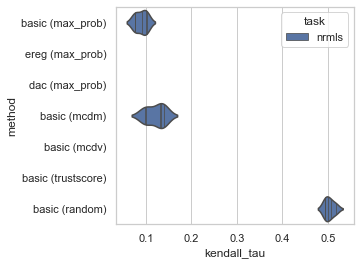

In [21]:
from spred.analytics import plot_evaluation_metric
plot_evaluation_metric(result_db, "kendall_tau")

In general, the **max_prob** confidence appears to work best on our new task over multiple trials, at least according to the kendall_tau metric. We can use the same function to visualize any other experiment statistic, e.g. aupr. 

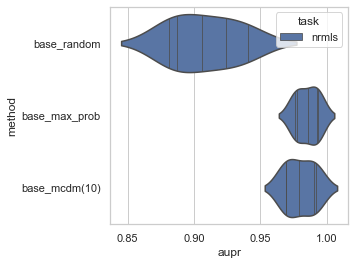

In [21]:
plot_evaluation_metric(result_db, "aupr")